# Freight Pricing API Time Series Example

This Jupyter Notebook displays a use case of how we could use the Freight Pricing API in order to conduct a time series analysis regarding the freight rates.
But first we should make sure that the Signal Ocean SDK is installed.

Set your subscription key acquired here: https://apis.signalocean.com/profile

In [1]:
signal_ocean_api_key = 'NotValid' #replace with your subscription key

We will also use PortAPI in order to choose Load & Discharge ports.

In [2]:
from signal_ocean import PortAPI, PortFilter, Connection

connection = Connection(api_key=signal_ocean_api_key)

port_api = PortAPI(connection)
load_port = port_api.get_ports(PortFilter(name_like='Gamba'))[0]
discharge_port = port_api.get_ports(PortFilter(name_like='Singapore'))[0]

In [3]:
from signal_ocean.freight_pricing import FreightPricingAPI,VesselType,VesselSubclass
from datetime import date

### Creating Time Series Data 

Time Series data are created by calling the Freight Pricing API iteratively. Τime Window and Frequency are determined by first_day, last_day and weeks_before variables. In this specific example we will get the freight rates for every week for the last 52 weeks. Reference day is the present day of week.

In [4]:
import pandas as pd
import datetime as dt

freight_pricing_api = FreightPricingAPI(connection)

last_day = date.today() + pd.DateOffset(days= -1) #- pd.DateOffset(days= (- or +)...) To pick a specific date
weeks_before = 52 # here the number of weeks back can change
first_day = last_day + pd.DateOffset(days= -weeks_before*7)

df_dict = {}

for i in range(1,weeks_before+1):
    next_date = first_day + pd.DateOffset(days=i*7)
    freight_pricing_collection = freight_pricing_api.get_freight_pricing(
        vessel_type=VesselType(id=1, name='Tanker'),
        load_port=load_port, 
        discharge_port=discharge_port,
        date=next_date,
        vessel_subclass=VesselSubclass.DIRTY)
    temp_dict = [o.__dict__ for o in freight_pricing_collection]
    for item in temp_dict:
        item['costs']= item['costs'].__dict__ 
        item['totals']= item['totals'].__dict__ 
    dataf = pd.json_normalize(data=temp_dict)
    fr_series = dataf['costs.freight_rate']
    df_dict[str(next_date)] = fr_series.values.tolist()
    
vessel_classes = dataf.vessel_class.tolist()
df_dict["vessel_class"] = vessel_classes

In [5]:
final_df = pd.DataFrame.from_dict(df_dict)
final_df

2019-11-03 00:00:00 2019-11-10 00:00:00 2019-11-17 00:00:00  \
0          21.9941275          19.9213825          19.0001625   
1          28.4426675           22.800195          27.5214475   
2          25.6790075          25.6790075            42.37612   

  2019-11-24 00:00:00 2019-12-01 00:00:00 2019-12-08 00:00:00  \
0          25.9093125           27.406295          21.9941275   
1          30.0548025            29.47904            33.62453   
2            49.28527            49.28527          44.1034075   

  2019-12-15 00:00:00 2019-12-22 00:00:00 2019-12-29 00:00:00  \
0          24.2971775          27.0608375          27.0608375   
1          34.4305975            36.38819           42.145815   
2          44.1034075            49.28527           50.436795   

  2020-01-05 00:00:00  ... 2020-08-30 00:00:00 2020-09-06 00:00:00  \
0            30.27816  ...            9.771588            8.808192   
1           41.426028  ...           14.175684           11.147868   
2           58.216644  ...            19.26792            18.57978   

  2020-09-13 00:00:00 2020-09-20 00:00:00 2020-09-27 00:00:00  \
0           11.285496           11.147868           10.046844   
1           12.661776           11.973636           11.147868   
2            18.57978            18.57978            18.57978   

  2020-10-04 00:00:00 2020-10-11 00:00:00 2020-10-18 00:00:00  \
0            9.496332            9.083448            9.083448   
1           11.836008           11.285496           11.285496   
2            18.57978            18.57978            18.57978   

  2020-10-25 00:00:00 vessel_class  
0            9.221076         VLCC  
1           10.459728      Suezmax  
2            19.26792      Aframax  

[3 rows x 53 columns]

Transposed dataframe is helpfull for the visualization of the data

In [6]:
final_df_transposed = final_df.set_index("vessel_class").T.rename_axis('Date')
final_df_transposed.head()

vessel_class               VLCC     Suezmax     Aframax
Date                                                   
2019-11-03 00:00:00  21.9941275  28.4426675  25.6790075
2019-11-10 00:00:00  19.9213825   22.800195  25.6790075
2019-11-17 00:00:00  19.0001625  27.5214475    42.37612
2019-11-24 00:00:00  25.9093125  30.0548025    49.28527
2019-12-01 00:00:00   27.406295    29.47904    49.28527

In [7]:
# extracting the transposed ton an excel file
final_df.to_excel('simpleDemoFreightPricing.xlsx')

## Visualizing the results in a graph

In [8]:
# creating x axis for the graph
variables_dict={}
for vc in  final_df.vessel_class.tolist():
    variables_dict["var%s" %vc] = final_df.loc[final_df.vessel_class==vc,str(first_day):str(last_day)].values.tolist()[0]

x_axis = final_df.loc[1:-1,str(first_day):str(last_day)].columns.tolist()
x_axis = [dt.datetime.strptime(x[0:10], '%Y-%m-%d') for x in x_axis]


In [9]:
#restrain the y axis
import numpy as np

minim = np.amin(final_df.loc[:,str(first_day):str(last_day)].values)
maxim = np.amax(final_df.loc[:,str(first_day):str(last_day)].values)

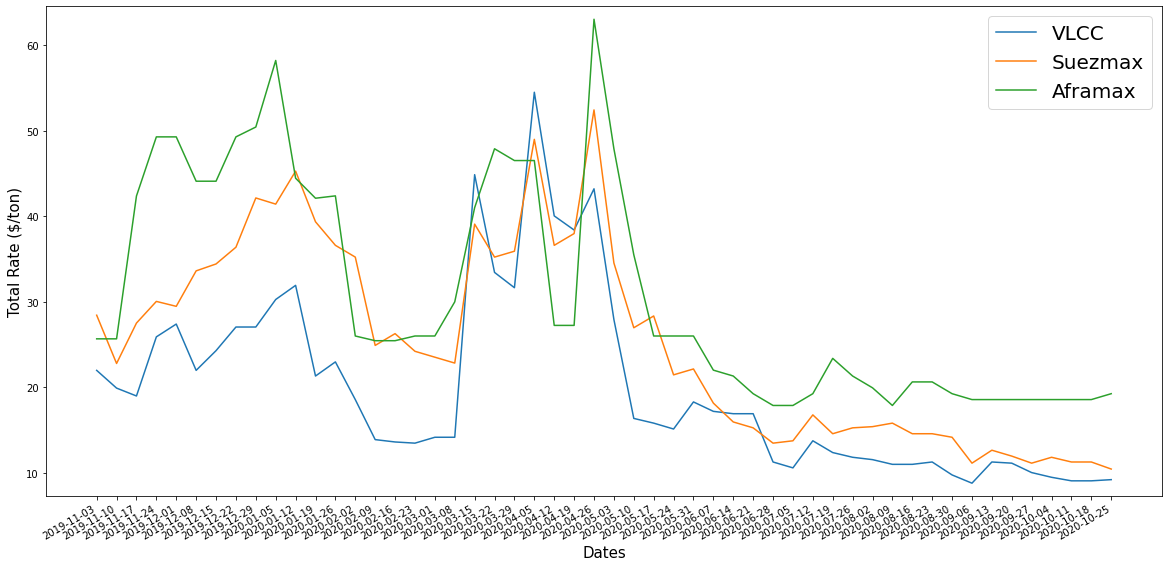

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import decimal

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.axes.set_ylim([minim - decimal.Decimal(1.5) ,maxim + decimal.Decimal(1.5)])
ax.axes.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

for key,val in variables_dict.items():
    ax.plot(x_axis,val,label=key[3:])

plt.xticks(x_axis)

plt.xlabel("Dates", fontsize=15)
plt.ylabel("Total Rate ($/ton)", fontsize=15)

plt.legend(fontsize=20)

# format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# rotate and align the tick labels so they look better
fig.autofmt_xdate()